# Blocks to points Ordinary Kriging interpolation - tutorial

## Table of Contents:

1. Read areal data,
2. Detect and remove outliers,
3. Create semivariogram model,
4. Read point data canvas,
5. Build map of interpolated values,
6. Show map of interpolated values with choropleth map of breast cancer rates.

## Level: Intermediate

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2022-08-23 | Updated tutorial for 0.3.0 version | @SimonMolinsky |
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function | @SimonMolinsky |
| 2021-12-06 | Behavior of `prepare_kriging_data()` function has changed | @SimonMolinsky |
| 2021-10-13 | Refactored TheoreticalSemivariogram (name change of class attribute) and refactored `calc_semivariance_from_pt_cloud()` functions to protect calculations from `NaN's`. | @ethmtrgt & @SimonMolinsky |
| 2021-05-11 | Refactored TheoreticalSemivariogram class | @SimonMolinsky |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated cancer rates data. | @SimonMolinsky |

## Introduction

This tutorial is based on the question of user *@ikey* from *Discord* channel of package (02/04/2021). Thank you *@ikey* for your engagement!

In short:

> Are we able to perform Semivariogram Regularization and Poisson Kriging if our point support represents only points without any values?

**No, it's not possible**. But there is a hack which we can use - we are able to interpolate missing values from areal centroids with Ordinary and Simple Kriging just like we do it with *regular points*. Why is it not possible with unknown points?

The idea behind semivariogram regularization of areal aggregates is to use semivariogram of points (values). And not any points, they must reflect ongoing process. As example, in the case of epidemiology:

1. We have areal counts of infections divided by POPULATION over some area.
2. We take POPULATION blocks (points) with number of inhabitants per block and use those as a support of our map. Thus we transform choropleth map into point map, and only to the points, where someone is living ==> someone may be infected. We skip large parts of map where risk of infection is not present because no one is living there.
3. And we finally obtain population-at-risk map of points or smoothed choropleth map of infection risk without large visual bias where large/small areas seems to be more important.

This works when we have specific **counts over area divided by other parameter** (time, population, probability, volume etc.). In this scenario we can find function which links our areal counts with those underlying variables and/or processes. Without support values we are not able to perform semivariogram regularization.

What we want to achieve may be done with Ordinary Kriging (because our points are really unknown) and semivariogram regularization is not required (and not possible without any values).

In summary we will learn how to:

- transform areal data into points,
- detect and remove outliers from data,
- create interpolated map from unknown points,
- visualize and save created map.

We use: 

- for point canvas: `samples/point_data/shapefile/regular_grid_points.shp`,
- for areal centroids: Breast cancer rates data is stored in the shapefile in folder `samples/regularization/cancer_data.gpkg`.

This tutorial requires understanding of concepts presented in **Semivariogram Estimation** and **Variogram Point Cloud** tutorials along with **Ordinary and Simple Kriging** notebook and (optionally) **Semivariogram Regularization** tutorial.

## Import packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from pyinterpolate.io_ops import prepare_areal_shapefile
from pyinterpolate.semivariance import build_variogram_point_cloud, show_variogram_cloud, remove_outliers
from pyinterpolate.semivariance import calc_semivariance_from_pt_cloud
from pyinterpolate.semivariance import TheoreticalSemivariogram
from pyinterpolate.kriging import Krige

## 1) Read areal data

In [2]:
areal = '../sample_data/areal_data/cancer_data.shp'
id_col = 'FIPS'
val_col = 'rate'
dataset = prepare_areal_shapefile(areal, id_column_name=id_col, value_column_name=val_col)
dataset[0]

array([25019,
       2132629.599151873, 557971.1559491967, 192.2], dtype=object)

In [3]:
data_centroids = dataset[:, -3:]
data_centroids[0]

array([2132629.599151873, 557971.1559491967, 192.2], dtype=object)

### Clarification:

Prepared areal shapefile has five columns: ```[area id, geometry, centroid x, centroid y, value]```. We don't need polygons' geometry and areas' id in the case of point kriging. Prepared array is sliced and in return we get array of centroids and their values. This is our base for modeling.

## 2) Detect and remove outliers

We check and clean data before semivariogram fit and Ordinary Kriging. Variogram Point Cloud is the best way to analyze data and detect outliers which may affect further analysis. We check and compare few different lags and step sizes and their respective point clouds. Then we will use those different number of ranges to create multiple semivariogram and Kriging models.

In [4]:
# Create analysis parameters

maximum_range = 300000

number_of_lags = [4, 8, 16]
step_sizes = [maximum_range / x for x in number_of_lags]

variogram_clouds = []

for step_size in step_sizes:
    variogram_cloud = build_variogram_point_cloud(data_centroids, step_size, maximum_range)
    variogram_clouds.append(variogram_cloud)

Lags per area: 3



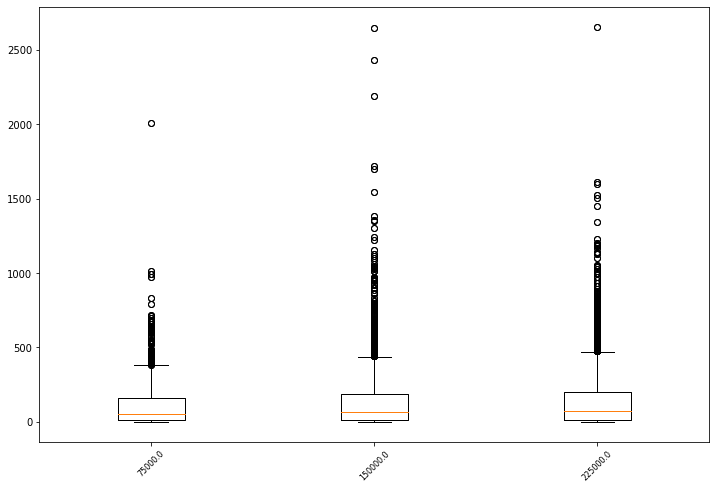


###########

Lags per area: 7



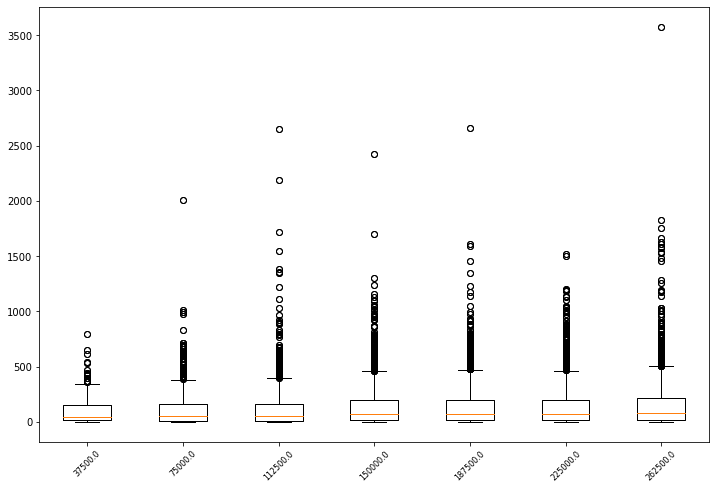


###########

Lags per area: 15



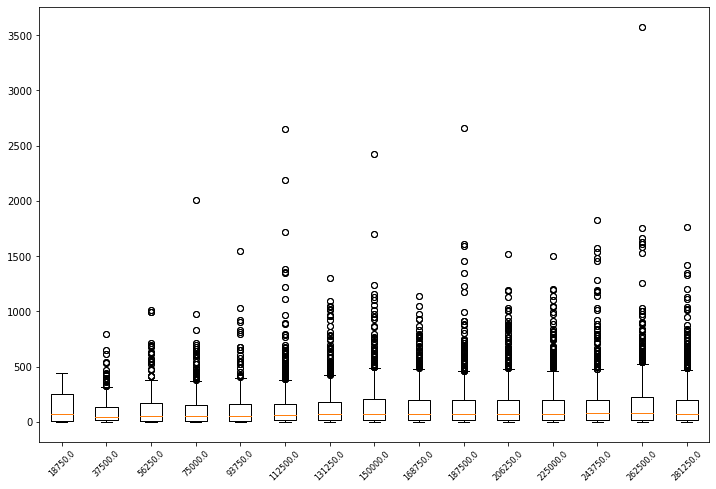


###########



In [5]:
for idx, lag in enumerate(number_of_lags):
    print(f'Lags per area: {lag-1}')
    print('')
    var_cloud = variogram_clouds[idx]
    show_variogram_cloud(var_cloud, figsize=(12, 8))
    
    print('\n###########\n')

In [6]:
# Now remove outliers from each lag

clouds_without_outliers = [remove_outliers(x) for x in variogram_clouds]

Lags per area: 3



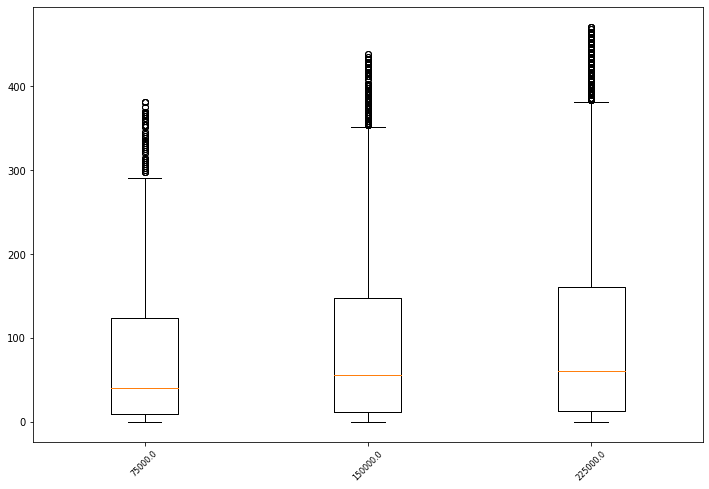


###########

Lags per area: 7



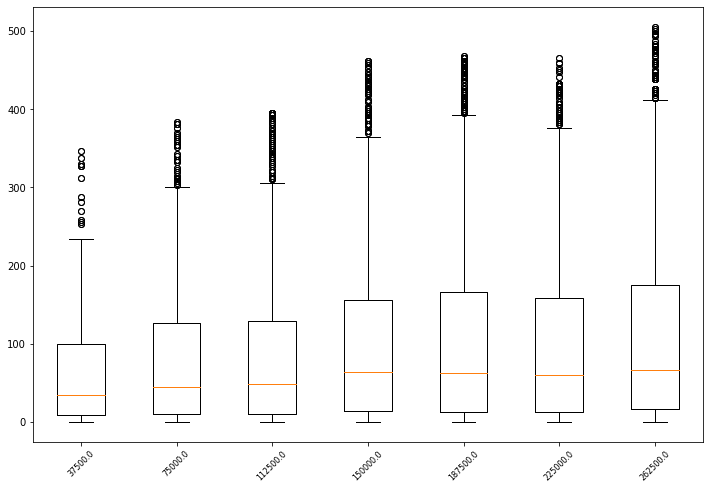


###########

Lags per area: 15



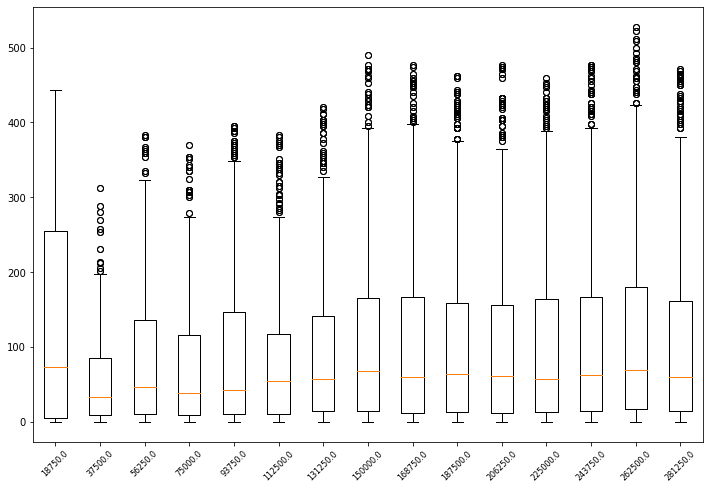


###########



In [7]:
# And show data without outliers

for idx, lag in enumerate(number_of_lags):
    print(f'Lags per area: {lag-1}')
    print('')
    var_cloud = clouds_without_outliers[idx]
    show_variogram_cloud(var_cloud, figsize=(12, 8))
    
    print('\n###########\n')

### Clarification:

It could be not visible, but we got rid off outliers from dataset. Look into **y** axes of variogram clouds with and without outliers for each lag. You hopefully see that maximum values after data cleaning are two times smaller. We can test different lags now to create semivariogram models.

## 3. Create semivariogram model

Semivariogram may be fitted manually or automatically. In this case we fit it automatically - we test multiple models and it's easier to use ```find_optimal_model()``` method of ```TheoreticalSemivariogram``` object.

In [8]:
theoretical_semivariograms = []

for idx, cloud_model in enumerate(clouds_without_outliers):
    
    print(f'Semivariance calculated for {number_of_lags[idx]-1} lags')
    print('')
    # Calculate experimental model
    exp_model = calc_semivariance_from_pt_cloud(cloud_model)
    
    # Assign experimental model and data to TheoreticalSemivariogram
    theo_semi = TheoreticalSemivariogram(points_array=data_centroids,
                                         empirical_semivariance=exp_model,
                                         verbose=True)
    theo_semi.find_optimal_model(weighted=False, number_of_ranges=number_of_lags[idx])
    theoretical_semivariograms.append(theo_semi)
    print('')
    print('Model parameters:')
    print('Nugget:', theo_semi.nugget)
    print('Sill:', theo_semi.sill)
    print('Range:', theo_semi.range)
    print('')
    print('#####')

Semivariance calculated for 3 lags

Model: spherical, error value: 8.241434104749422
Model: exponential, error value: 12.299614574268972
Model: linear, error value: 15.092343387172065
Chosen model: spherical, with value of: 8.241434104749422.

Model parameters:
Nugget: 0
Sill: 109.61454851876229
Range: 150000.0

#####
Semivariance calculated for 7 lags

Model: spherical, error value: 10.49400071519736
Model: exponential, error value: 9.602477078573983
Model: linear, error value: 10.936407998381856
Chosen model: exponential, with value of: 9.602477078573983.

Model parameters:
Nugget: 0
Sill: 109.61454851876229
Range: 75000.0

#####
Semivariance calculated for 15 lags

Model: spherical, error value: 17.905475707567167
Model: exponential, error value: 13.926371661388727
Model: linear, error value: 19.2756575640517
Chosen model: exponential, with value of: 13.926371661388727.

Model parameters:
Nugget: 0
Sill: 109.61454851876229
Range: 37500.0

#####


/Users/szymonmolinski/miniconda3/envs/pyint/lib/python3.7/site-packages/pyinterpolate/semivariance/semivariogram_fit/fit_semivariance.py:436: UserWarning: WARNING: linear model fitted to the experimental variogram is better than the core models!
  warnings.warn(warning_msg)


### Clarification:

_Exponential_ model was chosen in each case. This model offers lowest error of fitting. If we look only into the error value then we may assume that the best model is for 4 lags... but when we compare different parameters of semivariogram model we see interesting things.

**Nugget** of four lags is large and it's 30 cases per 100,000 inhabitants. Why is that? Model with only four lags catches large distance near the zero origin and it introduces bias. Other lags have nugget close to 0.

**Range** of the first model is very large compared to the areal bounds and it is a half of them. Range of 8 and 16 lags is closer to each other and more than two-three times smaller than range of 4 lags. It's the same effect of large spacing for 4 lags.

**Sill** is set to 109, it was derived from the grid search of potential sill values.

Summarizing: 4-lags model has lowest error of fit but largest nugget and range. 8- and 16-lags models have comparable nugget and range. Probably one of these models will be a better fit for Kriging. 

## 4. Read point data canvas

**Pyinterpolate** doesn't have function for read point data directly from shapefile (2021-02-07) but we can do it with **GeoPandas** package. **Pyinterpolate** uses **GeoPandas** under the hood so there is no problem with import of this package.

We read point file as the **GeoDataFrame** object which stores geometry column and data features as tables.

In [9]:
points = '../sample_data/point_data/regular_grid_points.shp'  # file with grid for analysis
gdf_pts = gpd.read_file(points)
gdf_pts.set_index('id', inplace=True)
gdf_pts.head()

,geometry
id,
81.0,POINT (1277277.671 441124.507)
82.0,POINT (1277277.671 431124.507)
83.0,POINT (1277277.671 421124.507)
84.0,POINT (1277277.671 411124.507)
85.0,POINT (1277277.671 401124.507)


Now we interpolate value for each point with Kriging. We use ```apply()``` on geometry column and create new columns of *GeoDataFrame* with interpolated results.

## 5. Build map of interpolated values

In [10]:
# Set kriging models

def krige_point(pt, k_model):
    """
    Function predicts value at unknown location.
    
    INPUT:
    
    :param pt: (shapely Point),
    :param k_model: (Krige)
    
    OUTPUT:
    
    :return: (float)
    """
    xloc = pt.x
    yloc = pt.y
    val = k_model.ordinary_kriging(unknown_location=[xloc, yloc])
    return pd.Series([val[0], val[1]])

kriging_models = []

for idx, semi_model in enumerate(theoretical_semivariograms):
    kriging_model = Krige(semivariogram_model=semi_model, known_points=data_centroids)
    col_name = 'lags_' + str(number_of_lags[idx]-1)
    err_col_name = 'e_' + col_name
    
    # Interpolate missing values and uncertainty
    gdf_pts[[col_name, err_col_name]] = gdf_pts.geometry.apply(krige_point, args=[kriging_model])
    
    # Append model
    kriging_models.append(kriging_model)

In [11]:
gdf_pts.head()

,geometry,lags_3,e_lags_3,lags_7,e_lags_7,lags_15,e_lags_15
id,,,,,,,
81.0,POINT (1277277.671 441124.507),131.666933,59.385887,131.337370,67.766214,134.8,130.459101
82.0,POINT (1277277.671 431124.507),128.719734,57.028773,131.168005,63.188088,134.8,136.839561
83.0,POINT (1277277.671 421124.507),127.941703,56.161701,130.426622,62.056515,125.8,132.505136
84.0,POINT (1277277.671 411124.507),127.776175,55.355213,129.984403,61.382583,125.8,129.323233
85.0,POINT (1277277.671 401124.507),127.439055,54.962963,129.025893,60.290506,125.8,133.023383


### Clarification:

This is rather complicated function in which we interpolate missing values as a new columns of **GeoDataFrame**. *Uncertainty* is assigned to interpolated results for further analysis.

Now we can save our **GeoDataFrame** as a shapefile...

In [12]:
# Save interpolation results

gdf_pts.to_file('interpolation_results_areal_to_point.shp')

or check results directly in a notebook!

## 6. Show map of interpolated values with choropleth map of breast cancer rates

In [13]:
# First read areal shapefile

gdf = gpd.read_file(areal)
gdf.head()

,rate,FIPS,rate_float,geometry
0,192.2,25019,192.2,"MULTIPOLYGON (((2115688.816 556471.240, 211569..."
1,166.8,36121,166.8,"POLYGON ((1419423.430 564830.379, 1419729.721 ..."
2,157.4,33001,157.4,"MULTIPOLYGON (((1937530.728 779787.978, 193751..."
3,156.7,25007,156.7,"MULTIPOLYGON (((2074073.532 539159.504, 207411..."
4,155.3,25001,155.3,"MULTIPOLYGON (((2095343.207 637424.961, 209528..."


Lag 3


<Figure size 432x288 with 0 Axes>

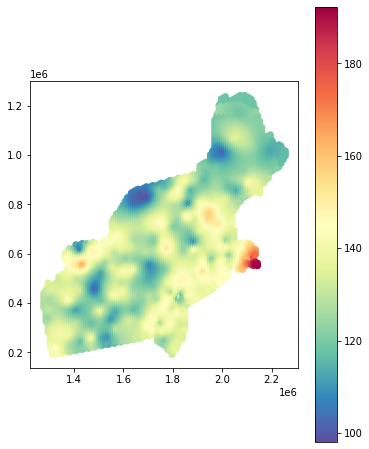

######
Lag 7


<Figure size 432x288 with 0 Axes>

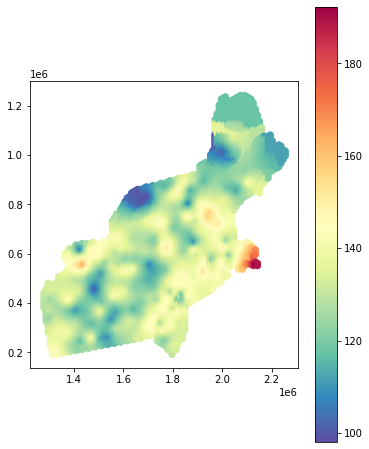

######
Lag 15


<Figure size 432x288 with 0 Axes>

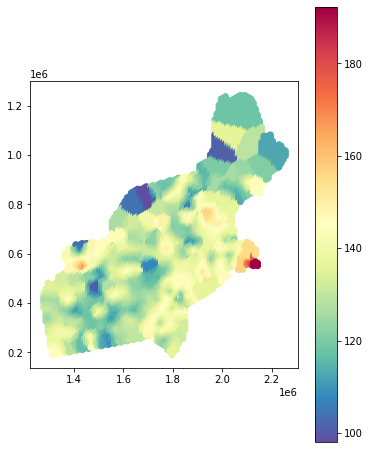

######


In [14]:
# Now compare results to choropleth maps

fs = (6, 8)

for lag in number_of_lags:
    print('Lag', lag-1)
    col_name = 'lags_' + str(lag-1)
    plt.figure()
    base = gdf.plot(figsize=fs, column='rate', cmap='Spectral_r', legend=True)
    gdf_pts.plot(ax=base, column=col_name, cmap='Spectral_r')
    plt.show()
    print('######')

### Clarification:

Visual inspection shows that:

1. Interpolated results are more smoothed over area and in the most part of a map they are similar to the rate observed in specific county.
2. Why map with the largest number of lags has the largest areas with similar values? (Large blocks). It is related to the maximum range of analysis. Optimal range is smallest for the area with 15 lags.
3. Are differences between those maps large or small?

To answer the last question we calculate the Mean Absolute Difference between each lag's interpolated results.

In [15]:
for lag1 in number_of_lags:
    print('LAG:', lag1-1)
    col_name1 = 'lags_' + str(lag1-1)
    for lag2 in number_of_lags:
        if lag1 == lag2:
            pass
        else:
            col_name2 = 'lags_' + str(lag2-1)
            mad = gdf_pts[col_name1] - gdf_pts[col_name2]
            mad = np.abs(np.mean(mad))
            print('')
            print(f'Mean Absolute Difference between lag {lag1-1} and lag {lag2-1} is {mad:.6f}')
            print('')

LAG: 3

Mean Absolute Difference between lag 3 and lag 7 is 0.035865


Mean Absolute Difference between lag 3 and lag 15 is 0.026831

LAG: 7

Mean Absolute Difference between lag 7 and lag 3 is 0.035865


Mean Absolute Difference between lag 7 and lag 15 is 0.062696

LAG: 15

Mean Absolute Difference between lag 15 and lag 3 is 0.026831


Mean Absolute Difference between lag 15 and lag 7 is 0.062696



### Clarification:

As you see those differences are really small. Each semivariogram model is similar in this case. In this case we can use **4-lag** model. It will be calculted faster than other models and it is still very similar to other models.

---